<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/advanced/dynamic-batching.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/advanced/dynamic-batching.ipynb)

# Dynamic Batching: What is it and why it is necessary sometimes

Batching examples together is a crucial optimization that significantly accelerates training processes. This, combined with distributed training across multiple GPUs, enables the training of models with large parameter counts on extensive datasets in a matter of days instead of months.

The conventional approach involves using a fixed batch size to group examples together. However, when each input has a different size, as is often the case in audio or natural language processing (NLP) applications, it necessitates padding each example in a batch to match the size of the largest one in that batch.

While this is a common practice, it introduces a potential inefficiency when the lengths of examples exhibit significant variance. In scenarios like audio and NLP applications, a substantial portion of computation is performed on padded values, leading to computational waste. To address this issue, dynamic batching becomes essential, allowing for more efficient and resource-conscious processing of variable-length sequences in the context of diverse machine learning tasks.





To illustrate this point, let's look, for example, at **MiniLibriSpeech** which is a subset of LibriSpeech. Let's download this dataset and other tools from the [data-io tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/data-loading-pipeline.html) which uses this same data.

In [1]:
%%capture
# here we download the material needed for this tutorial: images and an example based on mini-librispeech
!wget https://www.dropbox.com/s/b61lo6gkpuplanq/MiniLibriSpeechTutorial.tar.gz?dl=0
!tar -xvzf MiniLibriSpeechTutorial.tar.gz?dl=0
# downloading mini_librispeech dev data
!wget https://www.openslr.org/resources/31/train-clean-5.tar.gz
!tar -xvzf train-clean-5.tar.gz

Next, we install `speechbrain`:

In [2]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

Now, let's look at what is the length of each audio in this dataset and how it is distributed.

We can plot the histogram of the lengths for each audio in this dataset using `torchaudio`:

Number of audio files in MiniLibriSpeech train-clean-5:  1519


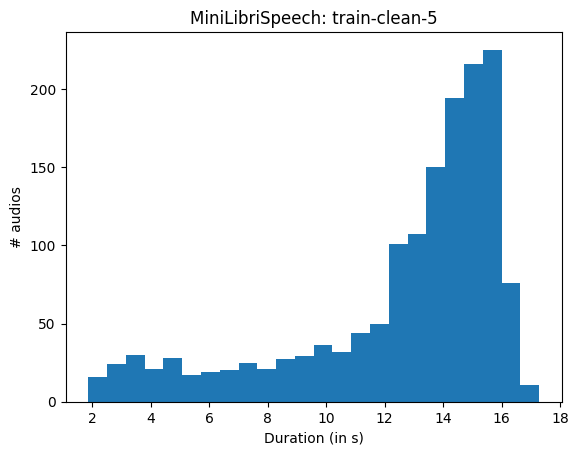

In [3]:
import matplotlib.pyplot as plt
import torchaudio
import numpy
import glob
import os

# fetching all flac files in MiniLibriSpeech
all_flacs = glob.glob(os.path.join("/content/LibriSpeech/train-clean-5", "**/*.flac"), recursive=True)

print("Number of audio files in MiniLibriSpeech train-clean-5: ", len(all_flacs))

# step-by-step
# collect durations
all_durations = numpy.zeros(len(all_flacs))
for i, audio in enumerate(all_flacs):
    wav_meta = torchaudio.info(audio)
    all_durations[i] = wav_meta.num_frames / wav_meta.sample_rate

# plot histogram
_ = plt.hist(all_durations, bins='auto')
plt.title("MiniLibriSpeech: train-clean-5")
plt.xlabel("Duration (in s)")
plt.ylabel("# audios")
plt.show()


We can see that most files have a length between 14 and 16 seconds. Moreover, there is a large variance in the file length.
So if we sample randomly without any particular strategy a certain number of examples (e.g., 8), pad them, and batch them together we will end up with lots of padded values.

This way, we will waste a significant portion of computation on padded values.



We can try to effectively compute the total number of samples which belong to padding when iterating over the whole dataset with a fixed batch size.


We follow here SpeechBrain data preparation best practices.
We parse all examples into a `.json` file so that parsing occurs only once and not at the start of each new experiment. In fact, parsing many small files can take a lot of time on networked storage or slow physical hard-drives.

In [4]:
# prepare LibriSpeech dataset using pre-made, downloaded parse_data.py script from
# the data-io tutorial available here: https://speechbrain.readthedocs.io/en/latest/tutorials/basics/data-loading-pipeline.html
from parse_data import parse_to_json
parse_to_json("/content/LibriSpeech/train-clean-5")
# this produced a manifest data.json file:

We can briefly look at each `.json` file. In particular we are interested in the `length` field which contains the length in samples for each audio in the dataset.

In [5]:
!tail -n 20 data.json

    },
    "4640-19188-0038": {
        "file_path": "/content/LibriSpeech/train-clean-5/4640/19188/4640-19188-0038.flac",
        "words": "THE FIFTH MAN WAS SAVED",
        "spkID": "speaker_4640",
        "length": 41200
    },
    "4640-19188-0005": {
        "file_path": "/content/LibriSpeech/train-clean-5/4640/19188/4640-19188-0005.flac",
        "words": "COME SAID HE YOU MUST HAVE A LITTLE PITY DO YOU KNOW WHAT THE QUESTION IS HERE IT IS A QUESTION OF WOMEN SEE HERE ARE THERE WOMEN OR ARE THERE NOT ARE THERE CHILDREN OR ARE THERE NOT",
        "spkID": "speaker_4640",
        "length": 247920
    },
    "4640-19188-0035": {
        "file_path": "/content/LibriSpeech/train-clean-5/4640/19188/4640-19188-0035.flac",
        "words": "DO YOU DESIGNATE WHO IS TO REMAIN YES SAID THE FIVE CHOOSE WE WILL OBEY YOU MARIUS DID NOT BELIEVE THAT HE WAS CAPABLE OF ANOTHER EMOTION",
        "spkID": "speaker_4640",
        "length": 184720
    }
}

We can use this `.json` manifest file to instantiate a SpeechBrain `DynamicItemDataset` object.

If this is not clear refer to the [data-io tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/data-loading-pipeline.html).

We also define a `data-io pipeline` to read the audio file.

In [6]:
# initializing a sb dataset object from this json
from speechbrain.dataio.dataset import DynamicItemDataset
import speechbrain
train_data = speechbrain.dataio.dataset.DynamicItemDataset.from_json("data.json")
# we define a pipeline to read audio
@speechbrain.utils.data_pipeline.takes("file_path")
@speechbrain.utils.data_pipeline.provides("signal")
def audio_pipeline(file_path):
      sig = speechbrain.dataio.dataio.read_audio(file_path)
      return sig
# setting the pipeline
train_data.add_dynamic_item(audio_pipeline)
train_data.set_output_keys(["signal", "file_path"])
train_data[0]

{'signal': tensor([ 7.9346e-04,  6.7139e-04,  4.8828e-04,  ..., -2.1362e-04,
         -1.2207e-04,  3.0518e-05]),
 'file_path': '/content/LibriSpeech/train-clean-5/3664/178355/3664-178355-0029.flac'}

Voilà, we now can start to iterate over this dataset using a torch `Dataloader`.
By using `PaddedBatch` as a `collate_fn` SpeechBrain will handle padding automatically for us. Neat!

We can also define a simple function `count_samples` to count samples that belong to padding in each batch

In [7]:
import torch
import time
from torch.utils.data import DataLoader
from speechbrain.dataio.batch import PaddedBatch

# counting tot padded values when batching the dataset with batch_size = 8
batch_size = 32

# PaddedBatch will pad audios to the right
dataloader = DataLoader(train_data, collate_fn=PaddedBatch, batch_size=batch_size)

def count_samples(dataloader):
  true_samples = 0
  padded_samples = 0
  t1 = time.time()
  for batch in dataloader:
    audio, lens = batch.signal

    true_samples += torch.sum(audio.shape[-1]*lens).item()
    padded_samples += torch.sum(audio.shape[-1]*(1-lens)).item()

  elapsed = time.time() - t1
  tot_samples = true_samples + padded_samples
  return true_samples / tot_samples, padded_samples / tot_samples, elapsed


In [8]:
for i, d in enumerate(dataloader):
    print(d.signal)
    # few example are enough to demonstrate what's going on here
    if i == 2:
        break

PaddedData(data=tensor([[ 7.9346e-04,  6.7139e-04,  4.8828e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-9.7656e-04, -4.8828e-04, -2.7466e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.8311e-04,  9.1553e-05,  3.0518e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-4.8828e-04, -3.6621e-04, -4.8828e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -6.1035e-05, -3.6621e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.6294e-04, -8.8501e-04, -8.8501e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), lengths=tensor([0.7254, 0.9600, 0.9525, 0.9864, 0.8919, 0.9579, 0.2834, 0.9282, 0.5404,
        0.8429, 0.9552, 0.9667, 0.6845, 0.8650, 0.9164, 0.8892, 0.3215, 0.9579,
        0.7363, 0.7172, 0.8601, 0.8959, 0.8529, 0.7826, 1.0000, 0.9325, 0.9818,
        0.9679, 0.8974, 0.7914, 0.9912, 0.9319]))
PaddedData(data=tensor([[ 0.0006,  0.0003, -0.0003,  

Let's count the samples when using a fixed batch size of 32 (as above) and the examples are sampled randomly.

In [9]:
percent_true, percent_padded, elapsed = count_samples(dataloader)
print("Random Sampling: % True samples {:.1f}, % of padding {:.1f}, Total time {:.2f}s".format(percent_true*100, percent_padded*100, elapsed))

Random Sampling: % True samples 76.8, % of padding 23.2, Total time 11.06s


*We* are wasting more than 20% of computations in each training iteration on useless values which are only there to enable batched computations.

Can we avoid such waste, speed up training, and consume less energy?

Sure, we can simply sort the dataset according to the length of the examples in ascending or descending order and then batch the examples together.


In [10]:
# if you followed the data-io tutorial you already know that sorting is super simple:
sorted_data = train_data.filtered_sorted(sort_key="length")
dataloader = DataLoader(sorted_data, collate_fn=PaddedBatch, batch_size=batch_size)
percent_true, percent_padded, elapsed = count_samples(dataloader)
print("After sorting: % True samples {:.1f}, % of padding {:.1f}, Total time {:.2f}".format(percent_true*100, percent_padded*100, elapsed))

After sorting: % True samples 98.8, % of padding 1.2, Total time 10.65


That is quite a reduction. Now, we are almost not wasting any compute on padded values as we have minimized padding by taking audios with roughly the same length in each batch. Iterating over one epoch is also significantly faster.

But this means that we must train with a sorted dataset.
In some applications, this might hurt the performance as the network sees the examples always in the same order.

In other applications sorting the examples can instead bring better performance as it can be seen as a sort of curriculum learning. This is the case for example for our TIMIT recipes.

Dynamic Batching allows users to trade-off between full random sampling of the examples and deterministic sampling from sorted examples.

Another problem with fixed batch size is that we are under-utilizing our resources for the shortest examples.
Suppose we use a fixed batch size of 8, and our dataset is sorted in ascending order. This means we must have sufficient memory to train on the 8 longest examples. But we also train on the 8 shortest ones!
In many instances, we can afford to batch a larger number of shorter examples together and optimize the GPU usage.


## SpeechBrain `DynamicBatchSampler` class

SpeechBrain provides a useful abstraction to perform Dynamic Batching:

---

**DynamicBatchSampler**.

In particular, with the right settings, it allows us to train large models even with 12 GB VRAM GPUs in a reasonable time. When using high-performance high VRAM GPUs, instead, it can significantly reduce training time.

**This abstraction allows us to select a good trade-off between training speed, randomization of sampling, and VRAM usage.**

It is up to you, depending on your application scenario and hardware, which of these characteristics should be prioritized.








`DynamicBatchSampler` belongs to the `torch.utils.data` `Sampler` class and is a torch *Batch Sampler*:

Being a batch Sampler, it is just a *python generator*  which returns, at each call, a list containing the indexes of the examples which should be batched together by the `DataLoader` using the `collate_fn`. These indexes are used to fetch the actual examples in the `torch.utils.data.Dataset` class using the `__getitem__` method.

Here is an example with batch_size 2. The DataLoader is responsible for taking care of parallelization of the Dataset `__getitem__` method. The indexes of the examples are provided by the Batch Sampler.
For more info, you can refer to the official [Pytorch documentation on torch.utils.data](https://pytorch.org/docs/stable/data.html).

<!--img src="https://drive.google.com/uc?id=1bNaa6X_Rjnt7qyFiPf4Hz0Gi6XLh8fAw"/-->

### Using `speechbrain.dataio.samplers.DynamicBatchSampler`

`DynamicBatchSampler` has several input arguments upon instantiation and provides a great deal of flexibility.

We will practically illustrate what is the effect of some of these using MiniLibriSpeech and how each of these can change the trade-off between speed, randomization, and VRAM usage.

**NOTE:** you should be highly familiar with SpeechBrain [data-io](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/data-loading-pipeline.html) to follow this tutorial.

In [11]:
# initializing a sb dataset object from this json
from speechbrain.dataio.dataset import DynamicItemDataset
import speechbrain

# we instantiate here the train data dataset from the json manifest file
train_data = DynamicItemDataset.from_json("data.json")

# we define a pipeline to read audio
@speechbrain.utils.data_pipeline.takes("file_path")
@speechbrain.utils.data_pipeline.provides("signal")
def audio_pipeline(file_path):
      sig = speechbrain.dataio.dataio.read_audio(file_path)
      return sig

# setting the pipeline
train_data.add_dynamic_item(audio_pipeline)
train_data.set_output_keys(["signal", "file_path"])

Crucially to use `DynamicBatchSampler` **it is important that the manifest/dataset description file** (`json` or `csv`) **contains**, for each example, **an entry which specifies the duration or length of each example**.
The `DynamicBatchSampler` will use this information to batch efficiently examples together.

In [12]:
!tail -n 10 data.json

        "spkID": "speaker_4640",
        "length": 247920
    },
    "4640-19188-0035": {
        "file_path": "/content/LibriSpeech/train-clean-5/4640/19188/4640-19188-0035.flac",
        "words": "DO YOU DESIGNATE WHO IS TO REMAIN YES SAID THE FIVE CHOOSE WE WILL OBEY YOU MARIUS DID NOT BELIEVE THAT HE WAS CAPABLE OF ANOTHER EMOTION",
        "spkID": "speaker_4640",
        "length": 184720
    }
}

We can see that in this case we have a length key containing, for each audio, the length in samples.

#### Instantiating `DynamicBatchSampler`: Core Parameters

---
At its core, `DynamicBatchSampler` batches examples with similar lengths based on "buckets". Upon instantiation, based on the input args, several buckets are created. These buckets define a number of contiguous intervals e.g. $0\leq x < 200, 200 \leq x < 400$ and so on.  
Examples whose lengths fall into a certain bucket are assumed as they have the same length and can be batched together. In some way, we are "quantizing" the lengths of the examples in the dataset.

In the Figure below we have N buckets, each defined by his right boundary.
For each bucket, we can have a different `batch_size` because we can fit more examples falling in the leftmost bucket than the rightmost one.

For the first bucket, the batch size is 8 because 1725 // 200 = 8.



<img width="600px" src="https://raw.githubusercontent.com/vitas-ai/tutorial-dynamic-batching-images/main/ManualBuckets-3.png"/>




In the Figure below we illustrate how 14 examples with different lengths are "bucketized": 3 examples in the first bucket, 5 examples in the second, 2 in  the third, 2 in the fourth and one in the last.

One example is discarded because it is too long (its length is more than `max_batch_size`).

<img width="600px" src="https://raw.githubusercontent.com/vitas-ai/tutorial-dynamic-batching-images/main/ManualBuckets-4.png"/>

A minimal instantiation of `DynamicBatchSampler` requires four arguments at least:

1.   A `Dataset` object (`train_data` here, note it can also be validation or test set).
2.   `max_batch_length`: the maximum length we want in a batch. This will be the maximum aggregated length of all examples in a batch we are going to allow and must be chosen carefully to avoid OOM errors.
A higher number means we are going to have, on average, an higher batch size so you must apply the same "tricks" as when batch size is increased for standard fixed batch size training. <br/>E.g. increase learning rate.
3. `num_buckets`: number of buckets one wishes to use. If just one bucket is used, all examples can be batched together, and dynamic batching in this instance is the same as uniform random sampling of the examples.
If too many buckets are specified the training will be slow because some buckets will be half empty.
As a rule of thumb: num_buckets trades-off speed with randomization.
<br/>Low number -> better randomization, High number -> faster training.

4. `length_func`: function to be applied to each dataset element to get its length. In our case, we can see that the `.json` manifest contains a key *length* which specifies each audio length in samples. This can be used for example to convert the length into seconds or the number of feature frames. So that `max_batch_length` and the bucket boundaries will be specified not anymore in samples.


We can specify `max_batch_length` in terms of seconds

In [13]:
from speechbrain.dataio.sampler import DynamicBatchSampler

max_batch_len = 17*32

dynamic_batcher = DynamicBatchSampler(
    train_data,
    max_batch_length=max_batch_len,
    num_buckets=60,
    length_func=lambda x: x["length"] / 16000,
)

In [14]:
dynamic_batcher._ex_lengths['0']

11.98

In [15]:
len(dynamic_batcher)

41

In [16]:
for b in dynamic_batcher:
  print(len(b))

34
44
34
34
34
44
34
57
34
34
38
34
38
53
38
17
71
38
34
16
34
34
35
38
34
30
38
34
34
8
30
44
34
38
53
38
26
71
38
34
34


In [17]:
for b in dynamic_batcher:
    print("%.1f" % sum([train_data[i]['signal'].shape[0]/16000 for i in b]))

511.5
515.8
509.3
506.6
491.4
345.4
516.5
506.6
514.2
479.3
478.4
195.0
74.9
501.8
514.2
328.9
510.0
514.6
270.3
514.0
517.8
519.4
507.3
505.9
508.4
467.8
517.4
511.2
514.0
424.3
512.6
503.3
241.4
510.6
506.0
512.4
512.5
508.0
516.7
489.6
513.6


#### Using `DynamicBatchSampler`

Once this special batch sampler is instantiated it can be used in the standard Pytorch way by using it as a DataLoader argument:

In [18]:
dataloader = DataLoader(train_data, batch_sampler=dynamic_batcher, collate_fn=PaddedBatch)
# note that the batch size in the DataLoader cannot be specified when a batch sampler is used.
# the batch size is handled by the batch_sampler and in this case is dynamic

In [19]:
# we can iterate now over the data in an efficient way using dynamic batching.
# our DynamicBatchSampler will sample the index of the examples such that padding is minimized
# while PaddedBatch will handle the actual padding and batching.
# everything happens in parallel thanks to the torch DataLoader.
first_batch = next(iter(dataloader))
print(first_batch.signal.lengths.shape)

torch.Size([34])


In [20]:
first_batch.signal.data.shape

torch.Size([34, 255280])

In [21]:
percent_true, percent_padded, elapsed = count_samples(dataloader)
print("With Dynamic Batching: % True samples {:.1f}, % of padding {:.1f}, Total time {:.2f}s".format(percent_true*100, percent_padded*100, elapsed))

With Dynamic Batching: % True samples 92.1, % of padding 7.9, Total time 10.38s


**The amount of padded values is significantly reduced vs the fixed batch size and full uniform random sampling.**

It indeed is close to what is obtained with fully deterministic sorting and fixed batch size.
The difference is that, here, with the DynamiBatchSampler we can still allow for some randomness in the sampling strategy.

Moreover, by batching together examples changing the batch size we use our hardware at the fullest with each batch significantly speeding up training.

We can look at the maximum number of examples that are batched together:

In [22]:
len(dynamic_batcher)

41

Using the DynamicBatchSampler with the current parameters we have 41 batches.

While using a fixed batch size of 32 we would end up with:

In [23]:
len(train_data) // 32 + 1

48

so more training iterations, with more padded values --> longer training time.

Another way to use `DynamicBatchSampler` straightforwardly is by feeding it directly to the Brain class as an additional argument via `run_opts`. In this case, the Brain class will implicitly instantiate for you a `DataLoader`.

In [24]:
## dummy Brain class here with dummy model
class SimpleBrain(speechbrain.Brain):
  def compute_forward(self, batch, stage):
    return model(batch["signal"][0].unsqueeze(1))

  def compute_objectives(self, predictions, batch, stage):
    loss_dummy = torch.mean(predictions)
    return loss_dummy

In [25]:
model = torch.nn.Conv1d(1, 1, 3)
brain = SimpleBrain({"model": model}, opt_class=lambda x: torch.optim.SGD(x, 0.1), run_opts={"batch_sampler": dynamic_batcher})
brain.fit(range(1), train_data)

100%|██████████| 1519/1519 [00:37<00:00, 40.24it/s, train_loss=-75.8]


### Advanced Parameters: Full control over randomness, training speed, and VRAM consumption.
---
Right now we have explored the most basilar input args for `DynamicBatchSampler`.
Let's see more advanced parameters.

#### Controlling Randomness


Randomness in `DynamicBatchSampler` is controlled with `shuffle` and `batch_ordering`.

`shuffle` is a flag:

* if `true`, then dynamic batches are created based on random sampling (deterministically based on `epoch` and `seed` parameters) at each epoch (included upon `DynamicBatchSampler` instantiation or epoch 0);
* if `false`, then dynamic batches are created taking the examples from the database as they are. If the dataset is sorted in ascending or descending order this ordering is preserved. Note that if `false` the batches will be created once and never change during training (their permutation can change however see next).



Batch permutation depends on `batch_ordering`:

* `"random"` deterministically shuffles batches based on `epoch` and `seed` parameters
* `"ascending"` and `"descending"` sort the batches based on the duration of the longest example in the batch.

This argument is independent of `shuffle`.`shuffle` controls if we have to shuffle the examples before creating the batches. `batch_ordering` instead controls the shuffling of the batches after they have been created.
For example, if set to `"ascending"` the first batch returned by the batch sampler will be the one with the shortest example in the dataset (examples belonging to the leftmost bucket); while the last one will contain the longest example in the dataset.


NOTE: when iterating the `DynamicBatchSampler` (calling its `__iter__` function):

* dynamic batches are re-generated at each epoch if `shuffle == True`; or
* dynamic batches are permuted at each epoch if `batch_ordering == "random"`



Note that also `num_buckets` affects randomization of training. As we stated before if `num_buckets`-->1 we obtain full random sampling as all examples can be batched together at least if `shuffle` is True and `batch_ordering` is random. Curiously even if `num_buckets` is very large we also obtain full random sampling if `shuffle` is True and `batch_ordering` is random as practically every example in the dataset is batched alone (we will have closer to batch size == 1 and very slow training, probably you want to avoid this).

Here we create the batches by firstly shuffling the examples (so the batches will be different at each epoch) but then sort them so always the one with the shortest example comes first.

In [26]:
from speechbrain.dataio.sampler import DynamicBatchSampler

max_batch_len = 17*32

dynamic_batcher = DynamicBatchSampler(train_data,
        max_batch_length=max_batch_len,
        num_buckets= 60,
        length_func=lambda x: x["length"] / 16000,
        shuffle=True,
        batch_ordering="ascending"
        )

dataloader = DataLoader(train_data, batch_sampler=dynamic_batcher, collate_fn=PaddedBatch)

first_batch = next(iter(dataloader))

first_batch.signal[0].shape

torch.Size([71, 120480])

We can use instead descending order

In [27]:
from speechbrain.dataio.sampler import DynamicBatchSampler

max_batch_len = 17*32

dynamic_batcher = DynamicBatchSampler(train_data,
        max_batch_length=max_batch_len,
        num_buckets= 60,
        length_func=lambda x: x["length"] / 16000,
        shuffle=True,
        batch_ordering="descending"
        )

dataloader = DataLoader(train_data, batch_sampler=dynamic_batcher, collate_fn=PaddedBatch)

first_batch = next(iter(dataloader))

first_batch.signal[0].shape

torch.Size([30, 276400])

We can see that it now returns the batch with longest example.

##### Specifying manually the buckets

The argument `bucket_boundaries` can be used to manually specify how many buckets and what are their boundaries.

Needless to say, this arg will supersede `num_buckets`.

Let's see an example:

In [28]:
# trivial example just one bucket
dynamic_batcher = DynamicBatchSampler(train_data,
        max_batch_length=max_batch_len,
        bucket_boundaries=[max_batch_len],
        length_func=lambda x: x["length"])

It is easy to see that having just one bucket in this case all examples can be batched together. Even the shortest ones with the longest ones.

When just one bucket is used the `DynamicBatchSampler` will be inefficient as it will not minimize at all the amount of padding in each batch with a behavior similar to having a fixed batch size.

As we said previously we have the maximal amount of randomness in each batch as each example can be batched with any other one, regardless of its length.
We can now see more clearly the trade-off between training speed and randomness.



Here, in a more practical example, we use `bucket_boundaries` argument to specify a distribution for the buckets, given the distribution of the length of the audio files in our dataset, which we have plotted before and has, a **reversed log-normal distribution**.

In [29]:
# number of buckets --> less buckets more randomness
n_buckets = 40

# we can create n_buckets linearly spaced
max_batch_len = 20000
import numpy as np
buckets = np.linspace(0, max_batch_len, n_buckets)
buckets_bounds = buckets[1:].tolist()
dynamic_batcher = DynamicBatchSampler(train_data,
        max_batch_length=max_batch_len,
        bucket_boundaries=buckets_bounds,
        length_func=lambda x: x["length"] / 160)# length in terms of 10ms

dataloader = DataLoader(train_data, batch_sampler=dynamic_batcher, collate_fn=PaddedBatch)
percent_true, percent_padded, elapsed = count_samples(dataloader)
print("With Dynamic Batching: % True samples {:.1f}, % of padding {:.1f}, Total time {:.2f}\n".format(percent_true*100, percent_padded*100, elapsed))

import numpy as np
max_batch_len = 20000
n_buckets = 40
buckets = np.linspace(0, max_batch_len, n_buckets)
buckets[1:].tolist()

With Dynamic Batching: % True samples 89.8, % of padding 10.2, Total time 12.07



[512.8205128205128,
 1025.6410256410256,
 1538.4615384615386,
 2051.2820512820513,
 2564.102564102564,
 3076.923076923077,
 3589.74358974359,
 4102.5641025641025,
 4615.384615384615,
 5128.205128205128,
 5641.025641025641,
 6153.846153846154,
 6666.666666666667,
 7179.48717948718,
 7692.307692307692,
 8205.128205128205,
 8717.948717948719,
 9230.76923076923,
 9743.589743589744,
 10256.410256410256,
 10769.23076923077,
 11282.051282051281,
 11794.871794871795,
 12307.692307692309,
 12820.51282051282,
 13333.333333333334,
 13846.153846153846,
 14358.97435897436,
 14871.794871794871,
 15384.615384615385,
 15897.435897435897,
 16410.25641025641,
 16923.076923076922,
 17435.897435897437,
 17948.71794871795,
 18461.53846153846,
 18974.358974358973,
 19487.17948717949,
 20000.0]

*However*, having linearly spaced buckets when our length distribution is not uniform is sub-optimal.


Intuitively one better way to generate the buckets is using an exponential distribution as we can employ coarser buckets for longer examples.
Indeed, more padding for longer examples has less impact as overall the examples are longer.

In [30]:
# number of buckets --> less buckets more randomness
n_buckets = 40
# we can create n_buckets linearly spaced
max_batch_len = 20000
import numpy as np
batch_multiplier = 1.2
buckets_bounds = [200]
for x in range(n_buckets):
  buckets_bounds.append(buckets_bounds[-1]*batch_multiplier)

dynamic_batcher = DynamicBatchSampler(train_data,
        max_batch_length=max_batch_len,
        bucket_boundaries=buckets_bounds,
        length_func=lambda x: x["length"] / 160) # length in terms of 10ms

dataloader = DataLoader(train_data, batch_sampler=dynamic_batcher, collate_fn=PaddedBatch)
percent_true, percent_padded, elapsed = count_samples(dataloader)
print("With Dynamic Batching: % True samples {:.1f}, % of padding {:.1f}, Total time {:.2f}\n".format(percent_true*100, percent_padded*100, elapsed))

# number of buckets --> less buckets more randomness
n_buckets = 40
# we can create n_buckets linearly spaced
max_batch_len = 20000
import numpy as np
batch_multiplier = 1.2
buckets_bounds = [200]
for x in range(n_buckets):
  buckets_bounds.append(buckets_bounds[-1]*batch_multiplier)

buckets_bounds

With Dynamic Batching: % True samples 94.0, % of padding 6.0, Total time 10.81



[200,
 240.0,
 288.0,
 345.59999999999997,
 414.71999999999997,
 497.66399999999993,
 597.1967999999999,
 716.6361599999999,
 859.9633919999999,
 1031.9560703999998,
 1238.3472844799996,
 1486.0167413759996,
 1783.2200896511995,
 2139.8641075814394,
 2567.836929097727,
 3081.4043149172726,
 3697.685177900727,
 4437.222213480873,
 5324.666656177047,
 6389.599987412456,
 7667.519984894947,
 9201.023981873936,
 11041.228778248722,
 13249.474533898467,
 15899.36944067816,
 19079.24332881379,
 22895.09199457655,
 27474.110393491857,
 32968.93247219023,
 39562.71896662827,
 47475.26275995393,
 56970.31531194471,
 68364.37837433365,
 82037.25404920038,
 98444.70485904044,
 118133.64583084853,
 141760.37499701823,
 170112.44999642187,
 204134.93999570623,
 244961.92799484747,
 293954.31359381694]

In [31]:
len(dynamic_batcher._batches)

115

The amount of padding is reduced by using a more appropriate distribution.

---



In [32]:
lengths = np.array([torchaudio.info(x).num_frames for x in all_flacs])
from scipy.stats import beta
lengths = (lengths - np.amin(lengths)) / (np.amax(lengths)- np.amin(lengths))
lengths = np.clip(lengths, 1e-6, 1-1e-6)
a, b, loc, upper = beta.fit(lengths, floc=0, fscale=1)

## How to find good hyper-parameters and speed up training with DynamicBatchSampler


Training speed largely depends on:


*   `max_batch_length`: you want to set this as high as possible without getting OOM errors.
*   `num_buckets`: you want to avoid too low values and too high values for this parameter. As said previously: too low values and shorter examples will be batched also with longer ones, too high and almost all examples are batched alone. In both cases, your training will be extremely slow.


Finding a good value for  `max_batch_length`:


1.   Sort the dataset in descending order, set `shuffle = False` and `batch_ordering = "descending"` and do multiple short runs increasing  `max_batch_length` till you get an OOM error. Choose a value slightly below the one that leads to OOM.

Finding a good value for  `num_buckets`:

1. Without using `DynamicBatchSampler`, sort the dataset in descending order and find the maximum batch size that your GPU can handle. Look at the estimated time and number of batches for this configuration given in the very first iterations.
2. Sort the dataset in descending order, set `shuffle = False` and `batch_ordering = "descending"`  and `max_batch_length` with the value found before. Start with a `num_buckets` between 10 and 20 and do some guesses by doing some short runs looking at the estimated time and number of batches for each configuration. Choose the value which gives fewer batches than the one in step 1 (without dynamic batching) and whose estimated time is lower.

### Dynamic Batching with Web dataset
When working on an HPC cluster it is crucial to copy the dataset to the SSD of the local computing node. This step significantly improves the data-io performance and avoids slowing down a shared filesystem. In some cases, the dataset could be too big that might not fit into the SSD. This scenario is getting more common these days with the adoption of larger and larger datasets.

SpeechBrain supports [Webdataset](https://github.com/webdataset/webdataset), which allows users to efficiently read datasets from the shared file system.
The proposed Webdataset-based solution also supports dynamic batching. For more information, please take a look at [this tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/advanced/data-loading-for-big-datasets-and-shared-filesystems.html).

## Acknowledgements

SpeechBrain DynamicBatchSampler has been developed by Ralf Leibold and Andreas Nautsch with the help of Samuele Cornell

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```